In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from importlib import reload

import KernelTools
reload(KernelTools)
from KernelTools import vectorize_kfunc,dxx_k,diff2_k

from Kernels import setup_matern

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm

from jax.scipy.linalg import solve


import sympy as sym
from sympy import factorial
from sympy.series.series import series

import sympy2jax
from jax import custom_jvp
from jax import lax


# TODO: Define lower level function in terms of difference of vectors
# Manually apply chain rule to that difference of vectors

# Prototype

Array([3., 3., 3.], dtype=float64, weak_type=True)

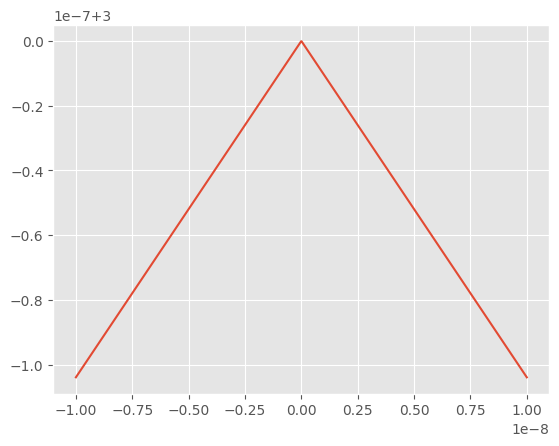

In [15]:
d2 = sym.symbols('d2',positive=True)
p = 1
eps = 1e-8

exp_multiplier = -sym.sqrt(2 * p + 1)
coefficients = [
    (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
    * (sym.sqrt(8 * p + 4))**(p - i) 
    for i in range(p + 1)]
powers = list(range(p,-1,-1))


matern = (
    sum([
        c * sym.sqrt((d2**power)) for c,power in zip(coefficients,powers)
        ]
    )
        *sym.exp(exp_multiplier * sym.sqrt(d2))
)

matern_func_raw = sympy2jax.SymbolicModule(matern)
matern_func = lambda d2:matern_func_raw(d2 = d2)



diff = sym.simplify(sym.Derivative(matern,d2,evaluate = True))
diff_mod = sympy2jax.SymbolicModule(diff)
jax_matern_diff = custom_jvp(lambda d2:diff_mod(d2 = d2))

diff2 = sym.simplify(sym.Derivative(matern,(d2,2),evaluate = True))
diff2_mod = sympy2jax.SymbolicModule(diff2)
jax_matern_diff2 = lambda d2:diff2_mod(d2 = d2)

@custom_jvp
def maternbase(d2):
   return matern_func(d2)

@maternbase.defjvp
def maternjvp(primals,tangents):
  x, = primals
  x_dot, = tangents
  ans = maternbase(x)
  ans_dot = jax_matern_diff(x)*x_dot
  return ans,ans_dot

@jax_matern_diff.defjvp
def materndiffjvp(primals,tangents):
  x, = primals
  x_dot, = tangents
  ans = jax_matern_diff(x)
  ans_dot = jax_matern_diff2(x)*x_dot
  return ans,ans_dot


def k(x,y):
    d2 = jnp.sum((x-y)**2+1e-32)
    return maternbase(d2)


kvec = jax.vmap(k,in_axes = (None,0))
kvgg = jax.vmap(jax.grad(jax.grad(k,1),0),in_axes=(None,0))
extent = 1e-8
grid = jnp.linspace(-extent,extent,1000)
plt.plot(grid,kvgg(0.,grid))

kvgg(0.,jnp.zeros(3))

In [16]:
def get_sympy_matern(p):
    d2 = sym.symbols('d2',positive=True)
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))
    matern = (
        sum([
            c * sym.sqrt((d2**power)) for c,power in zip(coefficients,powers)
            ]
        )
            *sym.exp(exp_multiplier * sym.sqrt(d2))
    )
    return d2,matern

In [17]:
p = 1
d2,sp_matern = get_sympy_matern(p)
matern_derivatives = [sym.simplify(sym.Derivative(sp_matern,(d2,i),evaluate = True)) for i in range(1,p+2)]

matern_func_raw = sympy2jax.SymbolicModule(sp_matern)
matern = custom_jvp(lambda d2:matern_func_raw(d2 = d2))

jax_matern_derivatives = (
    [custom_jvp(lambda x:sympy2jax.SymbolicModule(f)(d2 = x)) for f in matern_derivatives[:-1]] + 
    [lambda x:sympy2jax.SymbolicModule(matern_derivatives[-1])(d2 = x + 1e-20)]
)

#Define custom jvp for matern using sympy2jax version
@matern.defjvp
def matern_jvp(primals,tangents):
   x, = primals
   x_dot, = tangents
   ans = matern(x)
   ans_dot = jax_matern_derivatives[0](x)*x_dot
   return ans,ans_dot


for f,fp in zip(jax_matern_derivatives[:-1],jax_matern_derivatives[1:]):
   @f.defjvp
   def f_jvp(primals,tangents):
      x, = primals
      x_dot, = tangents
      ans = f(x)
      ans_dot = fp(x)*x_dot
      return ans,ans_dot



Array([3., 3., 3.], dtype=float64, weak_type=True)

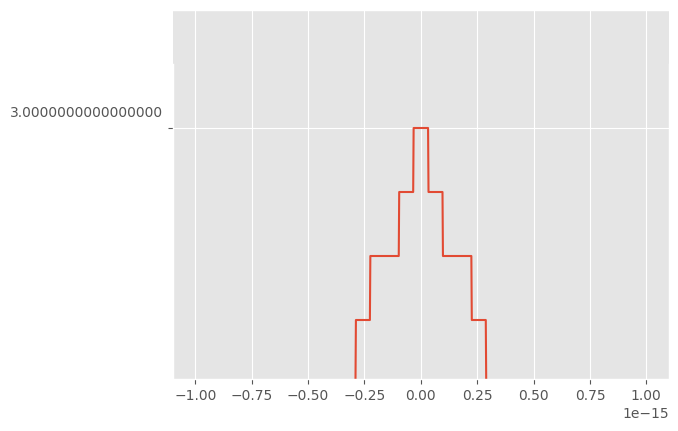

In [18]:
def k(x,y):
    d2 = jnp.sum((x-y)**2)
    return matern(d2)


kvec = jax.vmap(k,in_axes = (None,0))
kgg = jax.grad(jax.grad(k,1),0)
kvgg = jax.vmap(kgg,in_axes=(None,0))
extent = 1e-15
grid = jnp.linspace(-extent,extent,1001)
plt.plot(grid,kvgg(0.,grid))
plt.ylim(kgg(0.,0.)-2*extent,kgg(0.,0.)+extent)

kvgg(0.,jnp.zeros(3))

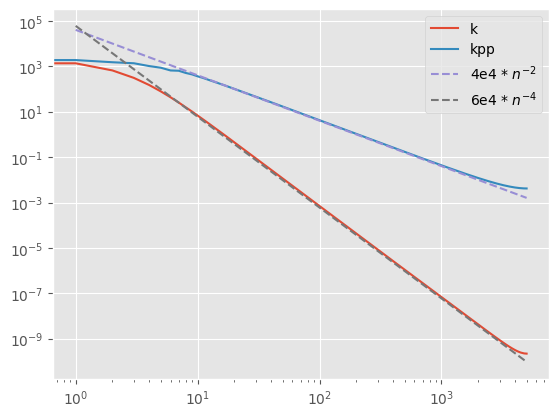

In [19]:
grid = jnp.linspace(-2,2,5000)
K = vectorize_kfunc(k)(grid,grid)
plt.plot(jnp.linalg.eigvalsh(K)[::-1],label = 'k')
grid = jnp.linspace(-2,2,5000)
K = vectorize_kfunc(kgg)(grid,grid)
plt.plot(jnp.linalg.eigvalsh(K)[::-1],label = 'kpp')
plt.yscale('log')
plt.xscale('log')
plt.plot(jnp.arange(5000),40000*jnp.arange(5000.)**(-2),label = "4e4 * $n^{-2}$",ls = '--')
plt.plot(jnp.arange(5000),60000*jnp.arange(5000.)**(-4),label = "6e4 * $n^{-4}$",ls = '--')

plt.legend()
plt.show()

## Todo: put double where tricks on each of the derivatives??

In [70]:
def build_matern_core(p):
    d2,sp_matern = get_sympy_matern(p)
    matern_derivatives = [sym.simplify(sym.Derivative(sp_matern,(d2,i),evaluate = True)) for i in range(1,p+1)]
    matern_derivatives[-1] = sym.simplify(matern_derivatives[-1]*sym.sqrt(d2))
    power = 75
    matern_derivatives[-1] = sym.simplify(matern_derivatives[-1]/((sym.sqrt(d2 + 1e-150) - 1e-75)))

    matern_func_raw = sympy2jax.SymbolicModule(sp_matern)
    matern = custom_jvp(lambda d2:matern_func_raw(d2 = d2))

    jax_matern_derivatives = (
        [custom_jvp(lambda x:sympy2jax.SymbolicModule(f)(d2 = x)) for f in matern_derivatives[:-1]] + 
        [lambda x:sympy2jax.SymbolicModule(matern_derivatives[-1])(d2 = x)]
    )

    #Define custom jvp for matern using sympy2jax version
    @matern.defjvp
    def matern_jvp(primals,tangents):
        x, = primals
        x_dot, = tangents
        ans = matern(x)
        ans_dot = jax_matern_derivatives[0](x)*x_dot
        return ans,ans_dot
    

    for f,fp in zip(jax_matern_derivatives[:-1],jax_matern_derivatives[1:]):
        @f.defjvp
        def f_jvp(primals,tangents):
            x, = primals
            x_dot, = tangents
            ans = f(x)
            ans_dot = fp(x)*x_dot
            return ans,ans_dot
    return matern


In [75]:
mm = build_matern_core(4)
# mm = lambda d2:jnp.exp(-1*d2)

k = lambda x,y:mm(jnp.sum(x-y)**2+1e-150)
k_gauss = lambda x,y:jnp.exp(-(x-y)**2/2)

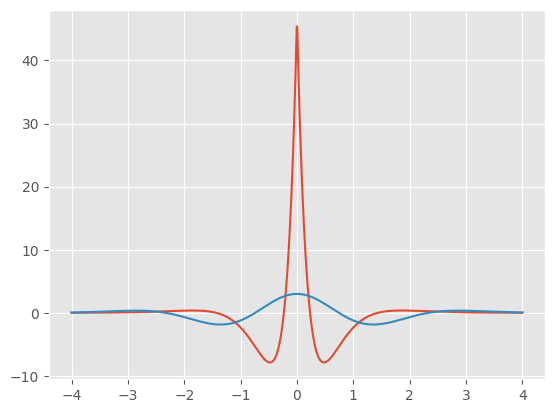

In [123]:
kp = diff2_k(diff2_k(k,0),1)
extent = 4.
grid = jnp.linspace(-extent,extent,1000)
# plt.plot(grid,jax.vmap(kp,in_axes=(None,0))(0.,grid))
plt.plot(grid,jax.vmap(kp,in_axes=(None,0))(0.,grid))

gauss_pp = diff2_k(diff2_k(k_gauss,0),1)
plt.plot(grid,jax.vmap(gauss_pp,in_axes=(None,0))(0.,grid))
# plt.ylim(kp(0.,1e-16)*(1-1e-13),kp(0.,1e-16)*(1+1e-14))

In [73]:
kp(0.,1e-16)*(1+1e-16) - kp(0.,1e-16)*(1-1e-16)

Array(3.55271368e-15, dtype=float64, weak_type=True)

### Something is going wrong above

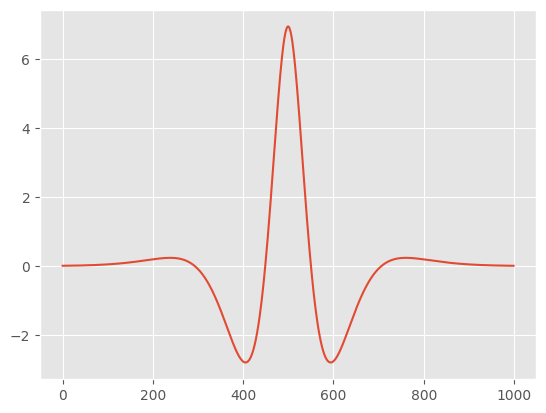

In [122]:
d2,sp_matern = get_sympy_matern(4)
x = sym.var('x')
y = sym.var('y')
sp_k = sp_matern.subs(d2,(x-y)**2)
r = sym.var('r',positive = True)
sympy_diff = sym.Derivative(sym.Derivative(sp_k,(x,2),evaluate = True),(y,2),evaluate = True)
sympy_diff= sympy_diff.subs(x,r+y)
matern_d2 = lambda r:sympy2jax.SymbolicModule(sympy_diff)(r = jnp.abs(r))
plt.plot(jax.vmap(matern_d2)(jnp.linspace(-5,5,1000)))

In [115]:
sympy_diff.subs(x,r+y)


81*(27*r**4/35 - 54*r**3/35 - 9*r**2/35 + 9*r/35 + 3/35)*exp(-3*r)

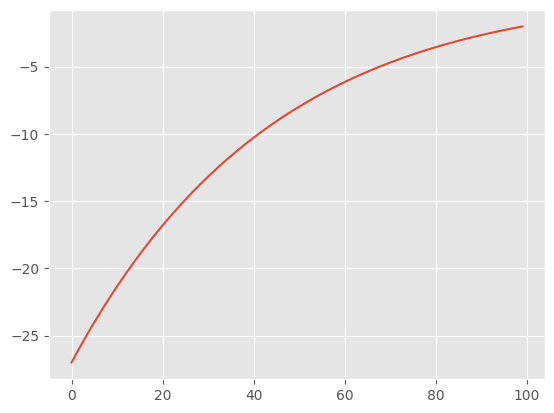